# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

# Описание данных

**Технологический процесс**
* **Rougher feed** — исходное сырье
* **Rougher additions (или reagent additions)** — флотационные реагенты: Xanthate, Sulphate, Depressant
    * Xanthate**— ксантогенат (промотер, или активатор флотации);
    * **Sulphate** — сульфат (на данном производстве сульфид натрия);
    * **Depressant** — депрессант (силикат натрия).
* **Rougher process (англ. «грубый процесс»)** — флотация
* **Rougher tails** — отвальные хвосты
* **Float banks** — флотационная установка
* **Cleaner process** — очистка
* **Rougher Au** — черновой концентрат золота
* **Final Au** — финальный концентрат золота

**Параметры этапов**
* **air amount** — объём воздуха
* **fluid levels** — уровень жидкости
* **feed size** — размер гранул сырья
* **feed rate** — скорость подачи

## Подготовка данных

###  Откроем  файлы и изучим их.

In [46]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import fbeta_score, make_scorer

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")

In [2]:
# для того, чтобы обеспечить "читаемость" всех столбцов,
# применим функцию pd.set_option()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

**Загрузим файлы:**
* gold_recovery_train_new.csv — обучающая выборка;
* gold_recovery_test_new.csv — тестовая выборка;
* gold_recovery_full_new.csv — исходные данные.

In [3]:
df_train = pd.read_csv('C:/Users/dmitr/OneDrive/Документы/DS справочник по всему материалу/gold_recovery_train_new.csv')
df_test = pd.read_csv('C:/Users/dmitr/OneDrive/Документы/DS справочник по всему материалу/gold_recovery_test_new.csv')
df_full = pd.read_csv('C:/Users/dmitr/OneDrive/Документы/DS справочник по всему материалу/gold_recovery_full_new.csv')

In [4]:
datasets = [df_train, df_test, df_full]
for dataset in datasets:
    display(dataset.head())

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [5]:
for dataset in datasets:
    display(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


None

In [6]:
for dataset in datasets:
    display(dataset.describe())

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,14117.000000,14149.000000,14049.000000,14149.000000,14063.000000,13863.000000,14149.000000,14148.000000,14134.000000,14103.000000,14149.000000,14145.000000,14148.000000,14145.000000,14148.000000,14147.000000,14148.000000,14146.000000,14148.000000,1.414800e+04,14148.000000,14148.000000,14149.000000,14149.000000,14049.000000,14141.000000,14005.000000,14071.000000,14149.000000,14120.000000,14141.000000,14113.000000,13721.000000,14149.000000,14149.000000,14127.000000,14149.000000,14149.000000,14148.000000,14149.000000,14149.000000,14149.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14149.000000,14149.000000,13713.000000,14149.000000,14149.000000,14149.000000,14147.000000,14139.000000,12544.000000,14149.000000,13932.000000,14148.000000,14128.000000,14148.000000,14145.000000,14148.000000,14148.000000,14148.000000,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5287.000000,5289.000000,5269.000000,5290.000000,5285.000000,5290.000000,5282.000000,5265.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5287.000000,5290.000000,5288.000000,5290.000000,5281.000000,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,1.544844e+03,-500.199527,9.371940,3.798082,489.800620,55.951097,37.716648,9.334682,13.855759,6.467745,13.922328,6.512103,1053.400166,-395.732530,1318.926879,-475.241428,1301.595477,-474.836671,1214.847960,-475.682272,1056.648995,-469.029688,997.949719,-470.482465,26.312630,-502.750897,21.949119,-501.987097,25.402926,-507.490314,2.098211e+01,-506.627916,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,1.247731e+02,31.045257,1.926264,0.954859,108.036326,19.081758,5.491415,1.619521,3.350852,1.065114,3.223769,0.886989,121.139309,91.085505,156.450366,45.649466,171.269667,45.859866,185.763319,47.844967,131.542839,59.325990,128.218869,60.759318,3.429852,28.756505,4.354961,34.582722,6.526457,47.620908,6.736179e+00,44.528673,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,4.039220e-32,-799.794250,0.568441,0.273677,0.002986,0.046369,1.393488,0.568632,0.001147,0.000568,0.000077,0.006985,-0.042069,-657.949759,-0.721806,-650.245277,-0.056636,-647.544439,-0.992219,-648.390665,-1.982295,-649.267537,-2.593390,-649.949283,0.20

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,19402.000000,19439.000000,19335.000000,19439.000000,19323.000000,19069.000000,19439.000000,19435.000000,19418.000000,19377.000000,19439.000000,1.943500e+04,19438.000000,1.943500e+04,19438.000000,1.943700e+04,19438.000000,1.943600e+04,19438.000000,1.943700e+04,19437.000000,19437.000000,19439.000000,19439.000000,19339.000000,19428.000000,19294.000000,19340.000000,19439.000000,19405.000000,19431.000000,19395.000000,18986.000000,19439.000000,19439.000000,19416.000000,19439.000000,19439.000000,19438.000000,19439.000000,19439.000000,19439.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19439.000000,19439.000000,19003.000000,19439.000000,19439.000000,19439.000000,19437.000000,19427.000000,17691.000000,19439.000000,19219.000000,19438.000000,19416.000000,19438.000000,19426.000000,19438.000000,19438.000000,19438.000000,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438

In [7]:
for dataset in datasets:
    display(dataset.isna().sum())

date                                                     0
final.output.concentrate_ag                              1
final.output.concentrate_pb                              1
final.output.concentrate_sol                           211
final.output.concentrate_au                              0
final.output.recovery                                    0
final.output.tail_ag                                     0
final.output.tail_pb                                   100
final.output.tail_sol                                    5
final.output.tail_au                                     0
primary_cleaner.input.sulfate                           20
primary_cleaner.input.depressant                        32
primary_cleaner.input.feed_size                          0
primary_cleaner.input.xanthate                         100
primary_cleaner.output.concentrate_ag                    0
primary_cleaner.output.concentrate_pb                   86
primary_cleaner.output.concentrate_sol                 2

date                                           0
primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_b_level       0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_c_level       0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatb

date                                                     0
final.output.concentrate_ag                              1
final.output.concentrate_pb                              1
final.output.concentrate_sol                           211
final.output.concentrate_au                              0
final.output.recovery                                    0
final.output.tail_ag                                     1
final.output.tail_pb                                   101
final.output.tail_sol                                    6
final.output.tail_au                                     0
primary_cleaner.input.sulfate                           24
primary_cleaner.input.depressant                        37
primary_cleaner.input.feed_size                          0
primary_cleaner.input.xanthate                         104
primary_cleaner.output.concentrate_ag                    0
primary_cleaner.output.concentrate_pb                  116
primary_cleaner.output.concentrate_sol                 3

In [8]:
for dataset in datasets:
    display(dataset.duplicated().sum())

0

0

0

**Вывод:**
* есть пропуски, но по большей части они не значительные, можно будет удалить
* дубликатов в датасетах нету
* столбец date является типом object необходимо заменить на тип datetime, остальные типы данных соответствует содержимому
* регистр названий столбцов в датасетах соответствует типу snake_case

### Проверим, что эффективность обогащения рассчитана правильно

recovery = ((C*(F-T))/(F*(C-T)))*100%, где:
* C — доля золота в концентрате после флотации/очистки, у нас это rougher.output.concentrate_au
* F — доля золота в сырье/концентрате до флотации/очистки, у нас это rougher.input.feed_au
* T — доля золота в отвальных хвостах после флотации/очистки, у нас это rougher.output.tail_au

In [9]:
#вычислим эффективность обогащения на обучающей выборке
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']

In [10]:
recovery_res = ((C * (F - T)) / (F * (C - T))) * 100
recovery_res.mean()

82.70450164550269

In [11]:
#сравним с данным прзнаком rougher.output.recovery
print(df_train['rougher.output.recovery'].mean())
print(abs(recovery_res.mean() - df_train['rougher.output.recovery'].mean()))

82.70450164550267
1.4210854715202004e-14


Разница между средним наших вычисленний и средним значений признака rougher.output.recovery равна 0, значит эффективность посчитана правильно.

In [12]:
print('MAE =', mean_absolute_error(recovery_res, df_train['rougher.output.recovery']))

MAE = 9.73512347450521e-15


Значение MAE между нашими расчётами и значением признака очень маленькое, что также доказывает, что эффективность обогащения рассчитана правильно.

### Проанализируем признаки, недоступные в тестовой выборке

In [13]:
missed_signs = set(df_train.columns) - set(df_test.columns)
display(missed_signs)
print(f'Количество признаков недоступных в тестовой выборке {len(missed_signs)}')

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Количество признаков недоступных в тестовой выборке 34


**Это параметры rougher, primary_cleaner, secondary_cleaner, final. Больше всего в тестовой выборке отсутствуют значения типа "параметры продукта", и 4 значения типа "расчетные характеристики". Отсутствие признаков можно обьяснить тем, что они рассчитываются почти в самом конце(по условию задачи).**

В тестовой выборки также отсутствуют целевые признаки rougher.output.recovery и final.output.recovery, которые будут нужны для расчета метрики качества. Добавим их в тестовую выборку, используя метод merge, в качестве индексов воспользуемся колонкой date.

In [14]:
df_test = df_test.merge(df_full.loc[:, ['date','rougher.output.recovery','final.output.recovery']], on='date')

### Проведём предобработку данных

Я считаю можно удалить колонку date, так как для дальнейшей работы не понадобится и модели будут быстрей обучаться.

In [15]:
df_train = df_train.drop('date', axis=1)
df_test = df_test.drop('date', axis=1)
print(f'Размер тренировочной выборки = {df_train.shape}; Размер тестовой выборки = {df_test.shape}')

Размер тренировочной выборки = (14149, 86); Размер тестовой выборки = (5290, 54)


Поскольку в описании проекта сказано, что данные индексируются датой и временем получения информации (признак date) и соседние по времени параметры похожи, заполним пропуски соседними значениями методом ffill.

In [16]:
for dataset in datasets:
  dataset.ffill(axis='rows', inplace=True)
#проверим
for dataset in datasets:
  display(dataset.isna().sum())

date                                                  0
final.output.concentrate_ag                           0
final.output.concentrate_pb                           0
final.output.concentrate_sol                          0
final.output.concentrate_au                           0
final.output.recovery                                 0
final.output.tail_ag                                  0
final.output.tail_pb                                  0
final.output.tail_sol                                 0
final.output.tail_au                                  0
primary_cleaner.input.sulfate                         0
primary_cleaner.input.depressant                      0
primary_cleaner.input.feed_size                       0
primary_cleaner.input.xanthate                        0
primary_cleaner.output.concentrate_ag                 0
primary_cleaner.output.concentrate_pb                 0
primary_cleaner.output.concentrate_sol                0
primary_cleaner.output.concentrate_au           

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

date                                                  0
final.output.concentrate_ag                           0
final.output.concentrate_pb                           0
final.output.concentrate_sol                          0
final.output.concentrate_au                           0
final.output.recovery                                 0
final.output.tail_ag                                  0
final.output.tail_pb                                  0
final.output.tail_sol                                 0
final.output.tail_au                                  0
primary_cleaner.input.sulfate                         0
primary_cleaner.input.depressant                      0
primary_cleaner.input.feed_size                       0
primary_cleaner.input.xanthate                        0
primary_cleaner.output.concentrate_ag                 0
primary_cleaner.output.concentrate_pb                 0
primary_cleaner.output.concentrate_sol                0
primary_cleaner.output.concentrate_au           

## Анализ данных

### Построим, как меняется концентрация металлов Au, Ag, Pb на различных этапах очистки.

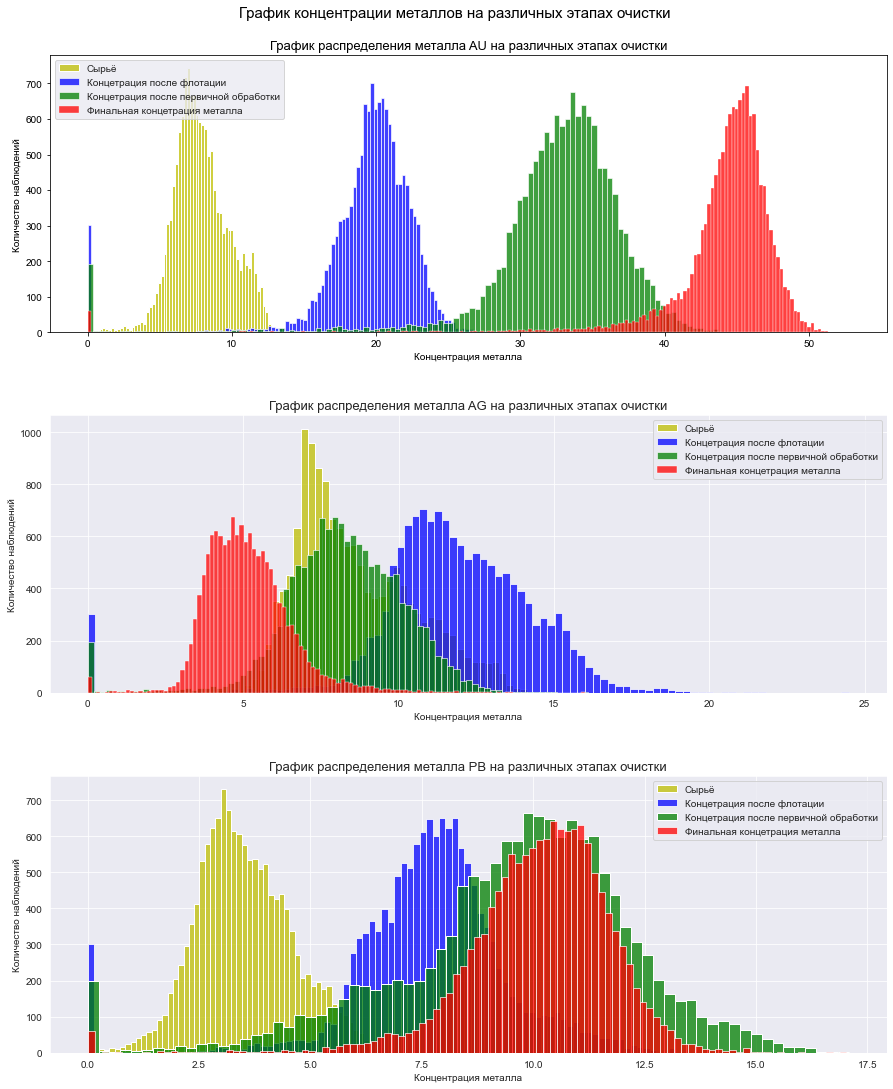

In [17]:
position = 0
plt.figure(figsize=[15, 17])
plt.subplots_adjust(top=0.94, wspace=0.2, hspace=0.3)
plt.suptitle('График концентрации металлов на различных этапах очистки', fontsize=15)
for metal in ['au', 'ag', 'pb']:
    position += 1
    plt.subplot(3, 1, position)
    plt.title(f'График распределения металла {str(metal).upper()} на различных этапах очистки', fontsize=13)
    sns.set_style('darkgrid')
    sns.histplot(df_train[f'rougher.input.feed_{metal}'], color='y', label='Сырьё')#, kd=False)
    sns.histplot(df_train[f'rougher.output.concentrate_{metal}'], color='b', label='Концетрация после флотации')#, kd=False)
    sns.histplot(df_train[f'primary_cleaner.output.concentrate_{metal}'], color='g', label='Концетрация после первичной обработки')#, kd=False)
    sns.histplot(df_train[f'final.output.concentrate_{metal}'], color='r', label='Финальная концетрация металла')#, kd=False)
    plt.xlabel('Концентрация металла')
    plt.ylabel('Количество наблюдений')
    plt.legend()
plt.show()

* **Анализируя концентрацию золота(Au) на разных этапах очистки, можно сделать вывод, что концентрация золота увеличивается с каждым этапом.**
* **Анализируя концентрацию серебра(Ag) на разных этапах очистки, можно сделать вывод, что концентрация серебра увеличивается только на этапе флотации, а с каждым следующим этапом она уменьшается.**
* **Анализируя концентрацию свинца(Pb) на разных этапах очистки, можно сделать вывод, что концентрация свинца увеличивается на этапе флотации и на первичной обработке, а затем на финальной обработке почти не меняется.**
* **Также можно заметить, что у каждого металла на различных этапах очистки есть аномальные значения.**

### Сравним распределения размеров гранул сырья на обучающей и тестовой выбоках.

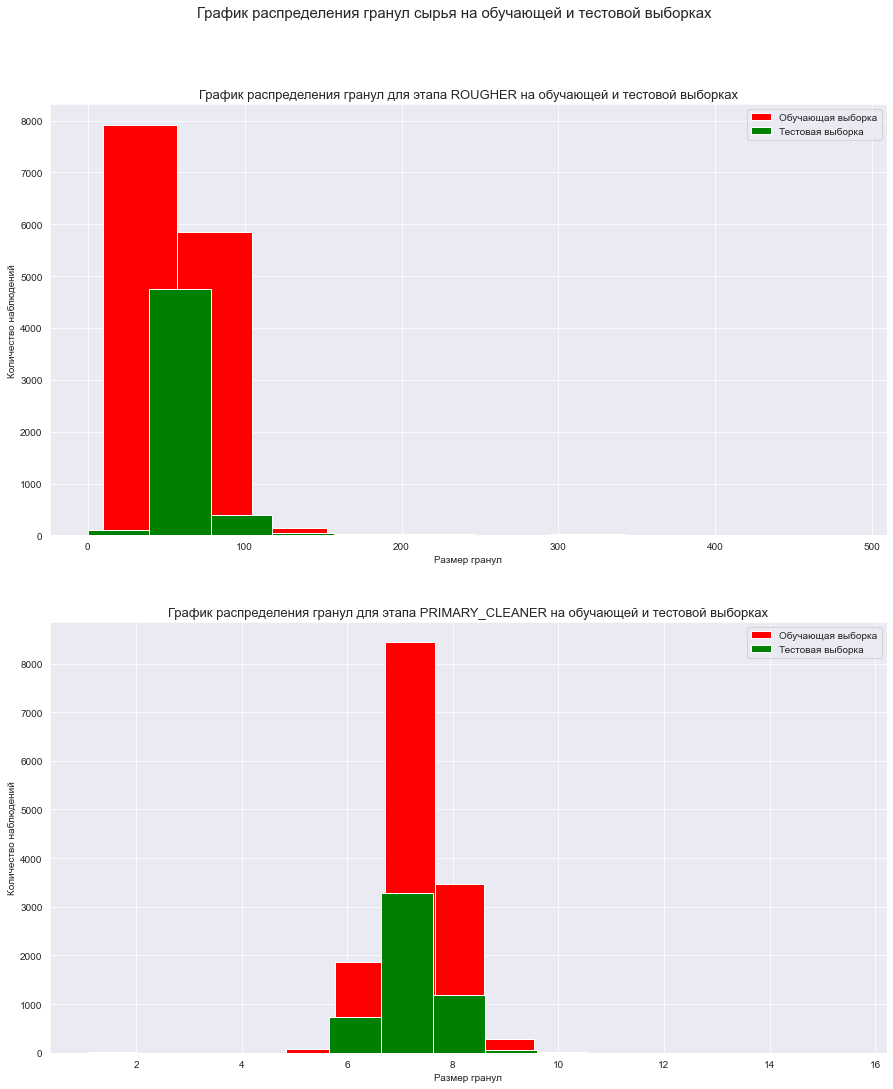

In [18]:
position = 0
plt.figure(figsize=[15, 17])
plt.subplots_adjust(top=0.90, wspace=0.2, hspace=0.2)
plt.suptitle('График распределения гранул сырья на обучающей и тестовой выборках', fontsize=15)
for stage in ['rougher', 'primary_cleaner']:
    position += 1
    plt.subplot(2, 1, position)
    plt.title(f'График распределения гранул для этапа {str(stage).upper()} на обучающей и тестовой выборках', fontsize=13)
    sns.set_style('darkgrid')
    plt.hist(df_train[f'{stage}.input.feed_size'], color='r', label='Обучающая выборка')#, density=True)
    plt.hist(df_test[f'{stage}.input.feed_size'], color='g', label='Тестовая выборка')#, density=True)
    plt.xlabel('Размер гранул')
    plt.ylabel('Количество наблюдений')
    plt.legend()
plt.show()

In [19]:
display(df_train['rougher.input.feed_size'].describe())
df_test['rougher.input.feed_size'].describe()

count    14005.000000
mean        60.110518
std         22.418485
min          9.659576
25%         48.973027
50%         55.373885
75%         66.080172
max        484.967466
Name: rougher.input.feed_size, dtype: float64

count    5289.000000
mean       55.951097
std        19.081758
min         0.046369
25%        43.906347
50%        50.841029
75%        62.431047
max       392.494040
Name: rougher.input.feed_size, dtype: float64

In [20]:
display(df_train['primary_cleaner.input.feed_size'].describe())
df_test['primary_cleaner.input.feed_size'].describe()

count    14149.000000
mean         7.322310
std          0.614062
min          1.080000
25%          6.960000
50%          7.290000
75%          7.700000
max         10.470000
Name: primary_cleaner.input.feed_size, dtype: float64

count    5290.000000
mean        7.266339
std         0.610219
min         5.650000
25%         6.890000
50%         7.250000
75%         7.600000
max        15.500000
Name: primary_cleaner.input.feed_size, dtype: float64

Метод describe показал, что средний размер гранул сырья на обучающей выборке - 60 микрон, а на тестовой - 56. 4 микрон - совсем не большая разница, так что будем считать, что распределения примерно равны.

### Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

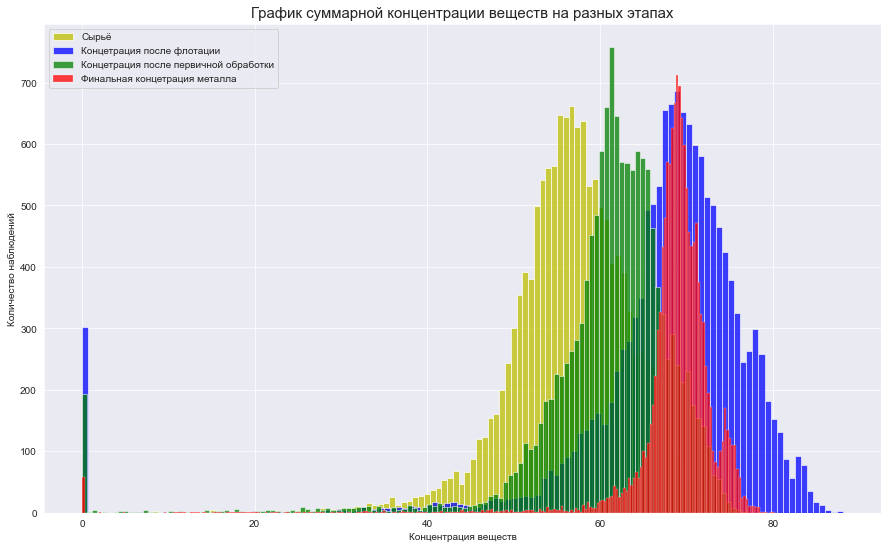

In [21]:
sum_concentrate_rougher_input = 0
sum_concentrate_rougher_output = 0
sum_concentrate_primary_cleaner_output = 0
sum_concentrate_final_output = 0
plt.figure(figsize=[15, 9])
for metal in ['au', 'ag', 'pb', 'sol']:
    sum_concentrate_rougher_input += df_train[f'rougher.input.feed_{metal}']
    sum_concentrate_rougher_output += df_train[f'rougher.output.concentrate_{metal}']
    sum_concentrate_primary_cleaner_output += df_train[f'primary_cleaner.output.concentrate_{metal}']
    sum_concentrate_final_output += df_train[f'final.output.concentrate_{metal}']
    
plt.title(f'График суммарной концентрации веществ на разных этапах', fontsize=15)
sns.set_style('darkgrid')
sns.histplot(sum_concentrate_rougher_input, color='y', label='Сырьё')#, kd=False)
sns.histplot(sum_concentrate_rougher_output, color='b', label='Концетрация после флотации')#, kd=False)
sns.histplot(sum_concentrate_primary_cleaner_output, color='g', label='Концетрация после первичной обработки')#, kd=False)
sns.histplot(sum_concentrate_final_output, color='r', label='Финальная концетрация металла')#, kd=False)
plt.xlabel('Концентрация веществ')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.show()

Суммарная концентрация веществ увеличивается к финальному этапу обработки, и диапозон распределения суммарной концентрации веществ уменьшается.

Для финального и этапа флотации для суммарной концентрации веществ присутствуют аномалии (значения в районе 0). Считаю необходимым удалить аномалии из данных, так как они могут негативно повлиять на качество обучения модели. Я считаю, они могли появиться в результате сбоя оборудования, значит нет гарантий, что остальные признаки правильные.

In [22]:
df_train = df_train[(df_train['rougher.output.concentrate_au'] != 0) & (df_train['rougher.output.concentrate_ag'] != 0) & (df_train['rougher.output.concentrate_pb'] != 0) & (df_train['rougher.output.concentrate_sol'] != 0)]
df_train = df_train[(df_train['final.output.concentrate_au'] != 0) & (df_train['final.output.concentrate_ag'] != 0) & (df_train['final.output.concentrate_pb'] != 0) & (df_train['final.output.concentrate_sol'] != 0)]

df_full = df_full[(df_full['rougher.output.concentrate_au'] != 0) & (df_full['rougher.output.concentrate_ag'] != 0) & (df_full['rougher.output.concentrate_pb'] != 0) & (df_full['rougher.output.concentrate_sol'] != 0)]
df_full = df_full[(df_full['final.output.concentrate_au'] != 0) & (df_full['final.output.concentrate_ag'] != 0) & (df_full['final.output.concentrate_pb'] != 0) & (df_full['final.output.concentrate_sol'] != 0)]

In [23]:
print(f'Размер тренировочной выборки = {df_train.shape}; Размер полной выборки = {df_full.shape}')

Размер тренировочной выборки = (13795, 86); Размер полной выборки = (18946, 87)


## Модель

Считаю необходимым удаление отсутствующих в тестовой выборке признаков (за исключением целевых признаков) из тренировочной выборки. Иначе в ходе обучения моделей может произойти утечка целевого признака.

In [24]:
extra_signs = set(df_train.columns) - set(df_test.columns)
print(f'Количество признаков для удаления из тренировочной выборки = {len(extra_signs)}')

Количество признаков для удаления из тренировочной выборки = 32


In [25]:
df_train = df_train.drop(set(df_train.columns)-set(df_test.columns), axis=1)
display(df_train.shape)
df_test.shape

(13795, 54)

(5290, 54)

Теперь видим, что кол-во признаков в тренировочной = кол-во признаков в тестовой выборке.

### Напишем функцию для вычисления итоговой sMAPE

Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных. Она симметричная, потому что одинаково учитывает масштаб и целевого признака, и предсказания. Метрику sMAPE вычислим так:

In [26]:
def smape_fun(target, predict):
    smape = (1/len(target))*np.sum((np.abs(target - predict))/((np.abs(target)+np.abs(predict))/2))*100
    return smape

In [28]:
smape_scorer = make_scorer(smape_fun, greater_is_better = False)

In [29]:
def final_smape_fun(rougher, final):
    final_smape = 0.25*rougher + 0.75*final
    return final_smape

### Обучим разные модели и оценим их качество кросс-валидацией. Выберим лучшую модель и проверим её на тестовой выборке

Подготовим данные для обучения моделей

In [30]:
features_train = df_train.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
target_train_rougher = df_train['rougher.output.recovery']
target_train_final = df_train['final.output.recovery']

features_test = df_test.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
target_test_rougher = df_test['rougher.output.recovery']
target_test_final = df_test['final.output.recovery']

In [31]:
features_train.ffill(axis='rows', inplace=True)
target_train_rougher.ffill(axis='rows', inplace=True)
target_train_final.ffill(axis='rows', inplace=True)

features_test.ffill(axis='rows', inplace=True)
target_test_rougher.ffill(axis='rows', inplace=True)
target_test_final.ffill(axis='rows', inplace=True)
features_test.shape

(5290, 52)

Для снижения возможного переобучения модели при кросс-валидации добавим перемешивание данных (переменную kf_tree применим для обучения моделей DecisionTreeRegressor и RandomForestRegressor).

In [32]:
kf_tree = KFold(5, shuffle=True, random_state=12345)

**Модель Линейной регрессии**

In [62]:
%%time

model_lin_rougher = LinearRegression()

lin_params_rougher = {
    'fit_intercept':[True,False],
    'normalize':[True,False],
    'copy_X':[True, False]
    }

grid_model_lin_rougher = RandomizedSearchCV(model_lin_rougher, lin_params_rougher, scoring=smape_scorer, cv=5, refit=True, verbose=1)

grid_model_lin_rougher.fit(features_train, target_train_rougher)
best_model_lin_rougher = grid_model_lin_rougher.best_estimator_
print(best_model_lin_rougher)
print(grid_model_lin_rougher.best_params_)
print(abs(grid_model_lin_rougher.best_score_))

model_lin_final = LinearRegression()

lin_params_final = {
    'fit_intercept':[True,False],
    'normalize':[True,False],
    'copy_X':[True, False]
    }
grid_model_lin_final = RandomizedSearchCV(model_lin_final, lin_params_final, scoring=smape_scorer, cv=5, refit=True, verbose=1)

grid_model_lin_final.fit(features_train, target_train_final)
best_model_lin_final = grid_model_lin_final.best_estimator_
print(best_model_lin_final)
print(grid_model_lin_final.best_params_)
print(abs(grid_model_lin_final.best_score_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
LinearRegression(normalize=False)
{'normalize': False, 'fit_intercept': True, 'copy_X': True}
7.293168019747325
Fitting 5 folds for each of 8 candidates, totalling 40 fits
LinearRegression(fit_intercept=False, normalize=True)
{'normalize': True, 'fit_intercept': False, 'copy_X': True}
11.006141709847494
CPU times: total: 4.22 s
Wall time: 2.18 s


Рассчитаем sMape для Линейной регрессии на обучающийся выборке

In [58]:
predictions_lin_rougher = best_model_lin_rougher.predict(features_train) 
smape_lin_rougher = smape_fun(target_train_rougher, predictions_lin_rougher)
print(smape_lin_rougher)

predictions_lin_final = best_model_lin_final.predict(features_train) 
smape_lin_final = smape_fun(target_train_final, predictions_lin_final)
print(smape_lin_final)

final_smape_lin_rougher = final_smape_fun(smape_lin_rougher, smape_lin_final)
print(final_smape_lin_rougher)

4.651520505709303
8.175564483867323
7.294553489327818


**Модель Дерева решения**

In [63]:
%%time

model_tree_rougher = DecisionTreeRegressor(random_state=12345)

tree_params_rougher = {
    'max_depth': range(1, 11),
    'min_samples_leaf': range(1, 6, 2)
    }

grid_model_tree_rougher = RandomizedSearchCV(model_tree_rougher, tree_params_rougher, scoring=smape_scorer, cv=kf_tree,
                                       refit=True, verbose=1, n_jobs=-1)

grid_model_tree_rougher.fit(features_train, target_train_rougher)
best_model_tree_rougher = grid_model_tree_rougher.best_estimator_
print(best_model_tree_rougher)
print(grid_model_tree_rougher.best_params_)
print(abs(grid_model_tree_rougher.best_score_))

model_tree_final = DecisionTreeRegressor(random_state=12345)

tree_params_final = {
    'max_depth': range(1, 11),
    'min_samples_leaf': range(1, 6, 2)
    }

grid_model_tree_final = RandomizedSearchCV(model_tree_final, tree_params_final, scoring=smape_scorer, cv=kf_tree,
                                     refit=True, verbose=1, n_jobs=-1)

grid_model_tree_final.fit(features_train, target_train_final)
best_model_tree_final = grid_model_tree_final.best_estimator_
print(best_model_tree_final)
print(grid_model_tree_final.best_params_)
print(abs(grid_model_tree_final.best_score_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
DecisionTreeRegressor(max_depth=10, min_samples_leaf=3, random_state=12345)
{'min_samples_leaf': 3, 'max_depth': 10}
3.687194347039624
Fitting 5 folds for each of 10 candidates, totalling 50 fits
DecisionTreeRegressor(max_depth=9, min_samples_leaf=3, random_state=12345)
{'min_samples_leaf': 3, 'max_depth': 9}
7.288716615437641
CPU times: total: 1.77 s
Wall time: 18.8 s


Рассчитаем sMape для Дерева решения на обучающийся выборке

In [64]:
predictions_tree_rougher = best_model_tree_rougher.predict(features_train) 
smape_tree_rougher = smape_fun(target_train_rougher, predictions_tree_rougher)
print(smape_tree_rougher)

predictions_tree_final = best_model_tree_final.predict(features_train) 
smape_tree_final = smape_fun(target_train_final, predictions_tree_final)
print(smape_tree_final)

final_smape_tree_rougher = final_smape_fun(smape_tree_rougher, smape_tree_final)
print(final_smape_tree_rougher)

2.7841034577143082
5.977506304058204
5.179155592472231


**Модель Случайного леса**

In [65]:
%%time

model_forest_rougher = RandomForestRegressor(random_state=12345)

forest_params_rougher = {
    'max_depth': range(1, 11),
    'min_samples_leaf': range(1, 6, 2),
    'n_estimators': range(10, 51, 10),
    }


grid_model_forest_rougher = RandomizedSearchCV(model_forest_rougher, forest_params_rougher, scoring=smape_scorer, cv=kf_tree,
                                         refit=True, verbose=1, n_jobs=-1)

grid_model_forest_rougher.fit(features_train, target_train_rougher)
best_model_forest_rougher = grid_model_forest_rougher.best_estimator_
print(best_model_forest_rougher)
print(grid_model_forest_rougher.best_params_)
print(abs(grid_model_forest_rougher.best_score_))

model_forest_final = RandomForestRegressor(random_state=12345)

forest_params_final = {
    'max_depth': range(1, 11),
    'min_samples_leaf': range(1, 6, 2),
    'n_estimators': range(10, 51, 10),
    }


grid_model_forest_final = RandomizedSearchCV(model_forest_final, forest_params_final, scoring=smape_scorer, cv=kf_tree,
                                       refit=True, verbose=1, n_jobs=-1)

grid_model_forest_final.fit(features_train, target_train_final)
best_model_forest_final = grid_model_forest_final.best_estimator_
print(best_model_forest_final)
print(grid_model_forest_final.best_params_)
print(abs(grid_model_forest_final.best_score_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
RandomForestRegressor(max_depth=10, min_samples_leaf=5, n_estimators=40,
                      random_state=12345)
{'n_estimators': 40, 'min_samples_leaf': 5, 'max_depth': 10}
3.0355407571978725
Fitting 5 folds for each of 10 candidates, totalling 50 fits
RandomForestRegressor(max_depth=10, min_samples_leaf=3, n_estimators=20,
                      random_state=12345)
{'n_estimators': 20, 'min_samples_leaf': 3, 'max_depth': 10}
6.505828058232507
CPU times: total: 23.9 s
Wall time: 4min 36s


Рассчитаем sMape для Случайного леса на обучающийся выборке

In [57]:
predictions_forest_rougher = best_model_forest_rougher.predict(features_train) 
smape_forest_rougher = smape_fun(target_train_rougher, predictions_forest_rougher)
print(smape_forest_rougher)

predictions_forest_final = best_model_forest_final.predict(features_train) 
smape_forest_final = smape_fun(target_train_final, predictions_forest_final)
print(smape_forest_final)

final_smape_forest_rougher = final_smape_fun(smape_forest_rougher, smape_forest_final)
print(final_smape_forest_rougher)

3.034942771530849
5.385271673948589
4.797689448344155


In [59]:
rezult = {'Линейная регрессия': 7.29, 'Дерево решения': 5.19, \
          'Случайный лес': 4.79}
rezult_df = pd.DataFrame(rezult, index=['Результаты итогового sMape разных моделей на обучающийся выборке'])
rezult_df

,Линейная регрессия,Дерево решения,Случайный лес
Результаты итогового sMape разных моделей на обучающийся выборке,7.29,5.19,4.79


Случайный лес показал лучший итоговый sMape на обучающийся выборке, поэтому выведим итоговый sMape по тестовой выборке на модели Случайного леса.

In [49]:
predictions_forest_rougher = best_model_forest_rougher.predict(features_test) 
smape_forest_rougher = smape_fun(target_test_rougher, predictions_forest_rougher)
print(smape_forest_rougher)

predictions_forest_final = best_model_forest_final.predict(features_test) 
smape_forest_final = smape_fun(target_test_final, predictions_forest_final)
print(smape_forest_final)

final_smape_forest_rougher = final_smape_fun(smape_forest_rougher, smape_forest_final)
print(final_smape_forest_rougher)

8.205841977849643
9.559755561539736
9.221277165617213


**Проверим модель на адекватность(вычислим показатель sMape для константной модели и сравним с результатами лучшей модели).**

In [50]:
model_dummy_rougher = DummyRegressor(strategy="mean")
model_dummy_rougher.fit(features_train, target_train_rougher)
predictions_dummy_rougher = model_dummy_rougher.predict(features_test)
smape_dummy_rougher = smape_fun(target_test_rougher, predictions_dummy_rougher)
print(smape_dummy_rougher)

model_dummy_final = DummyRegressor(strategy="mean")
model_dummy_final.fit(features_train, target_train_final)
predictions_dummy_final = model_dummy_final.predict(features_test)
smape_dummy_final = smape_fun(target_test_final, predictions_dummy_final)
print(smape_dummy_final)

final_smape_dummy_rougher = final_smape_fun(smape_dummy_rougher, smape_dummy_final)
print(final_smape_dummy_rougher)

9.066630806401538
10.074847136380473
9.82279305388574


Показатель модели RandomForestRegressor меньше показателя константной модели, что доказывает мы получили хорошее качество модели.

## Общий вывод:

In [61]:
rezult = {'Случайный лес': 9.22, 'Дамми модель': 9.82}
rezult_df = pd.DataFrame(rezult, index=['Результат итогового sMape'])
rezult_df

,Случайный лес,Дамми модель
Результат итогового sMape,9.22,9.82


Рассматривая данные после всей предобработки и анализа данных, можно сделать вывод, что лучшей моделью, которая показала лучший результат оказалась - модель Случайный лес. Ее лучшие параметры для целевого признака rougher.output.recovery: 'n_estimators'= 40, 'min_samples_leaf'= 5, 'max_depth'= 8, для final.output.recovery лучшие параметры: 'n_estimators'= 50, 'min_samples_leaf'= 3, 'max_depth'= 10. В итоге мы получили лучший sMape = 9.22 на тестовой выборке.